# A training example in Pytorch
## Introduction
### Task
In this notebook we will train a neural network to do a simple task. This will be a classification task : as explained in the first week of lectures, classification basically means to find a *decision boundary* over a space of real numbers. For representation purposes we will work with a 2D example : the decision boundary will be a cercle. More precisely, it will be the unity circle in the plan.
![](unitycircle.png)
### Sampling
We will generate points $(x_1,x_2)$ to classify, and their class $y$. The actual decision fonction is $y=1_{x_1^2+x_2^2<1}$.

To have a balanced dataset with about as many points in each class, we will sample uniformly over polar coordinates,  within the circle of center 0 and radius 2.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sample_points(n):
    # returns (X,Y), where X of shape (n,2) is the numpy array of points and Y is the (n) array of classes
    
    radius = np.random.uniform(low=0,high=2,size=n).reshape(-1,1) # uniform radius between 0 and 2
    angle = np.random.uniform(low=0,high=2*np.pi,size=n).reshape(-1,1) # uniform angle
    x1 = radius*np.cos(angle)
    x2=radius*np.sin(angle)
    y = (radius<1).astype(int).reshape(-1)
    x = np.concatenate([x1,x2],axis=1)
    return x,y

In [3]:
# Generate the data
trainx,trainy = sample_points(10000)
valx,valy = sample_points(500)
testx,testy = sample_points(500)

print(trainx.shape,trainy.shape)

(10000, 2) (10000,)


Our model will be a multi-layer perceptron with one hidden layer, and an output of size 2 since we have two classes. Since it is a binary classification task we could also use just one output and a zero threshold, but we will use two to illustrate the use of the pytorch Cross-Entropy loss (next week you will see how to use BinaryCrossEntropy for such a task).

As you know from the lectures, such a model cannot represent a circular boundary but could represent a polygonal boundary, whose number of sides is the number of neurons on the hidden layer. For example, with 6 hidden neurons the model could compute a hexagonal boundary that approximate the unity circle, such as :
![](hexagon.png)

Note that the optimal accuracy to expect from an hexagone approximating the unity circle is of about **xxxx**. Of course the trained model won't compute an actual hexagone, due to the activation that isn't a threshold, and the liberty of the final layer's weights (it does not have to be an AND). We can actually expect *better* accuracy than this.

In [4]:
def generate_single_hidden_MLP(n_hidden_neurons):
    return nn.Sequential(nn.Linear(2,n_hidden_neurons),nn.ReLU(),nn.Linear(n_hidden_neurons,2))
model1 = generate_single_hidden_MLP(6)

To train our model, we will need to feed it with tensors. Let's transform our generated numpy arrays :

In [5]:
trainx = torch.from_numpy(trainx).float()
valx = torch.from_numpy(valx).float()
testx = torch.from_numpy(testx).float()
trainy = torch.from_numpy(trainy)
valy = torch.from_numpy(valy)
testy = torch.from_numpy(testy)
print(trainx.type(),trainy.type())

torch.FloatTensor torch.IntTensor


Now we will define our training routine. There is the question of whether to perform our traing on CPU or GPU. The best thing to do is to use a flag variable that you will set, when you actually do the training.

In [6]:
def training_routine(net,dataset,n_iters,gpu):
    # organize the data
    train_data,train_labels,val_data,val_labels = dataset
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    
    # use the flag
    train_data,train_labels = train_data,train_labels.long()
    val_data,val_labels = val_data,val_labels.long()
    if gpu:
        train_data,train_labels = train_data.cuda(),train_labels.cuda()
        val_data,val_labels = val_data.cuda(),val_labels.cuda()
        net = net.cuda() # the network parameters also need to be on the gpu !
        print("Using GPU")
    else:
        train_data,train_labels = train_data.cpu(),train_labels.cpu()
        val_data,val_labels = val_data.cpu(),val_labels.cpu()
        net = net.cpu() # the network parameters also need to be on the gpu !
        print("Using CPU")
    for i in range(n_iters):
        # forward pass
        train_output = net(train_data)
        train_loss = criterion(train_output,train_labels)
        # backward pass and optimization
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Once every 100 iterations, print statistics
        if i%100==0:
            print("At iteration",i)
            # compute the accuracy of the prediction
            train_prediction = train_output.cpu().detach().argmax(dim=1)
            train_accuracy = (train_prediction.cpu().numpy()==train_labels.cpu().numpy()).mean() 
            # Now for the validation set
            val_output = net(val_data)
            val_loss = criterion(val_output,val_labels)
            # compute the accuracy of the prediction
            val_prediction = val_output.cpu().detach().argmax(dim=1)
            val_accuracy = (val_prediction.cpu().numpy()==val_labels.cpu().numpy()).mean() 
            print("Training loss :",train_loss.cpu().detach().numpy())
            print("Training accuracy :",train_accuracy)
            print("Validation loss :",val_loss.cpu().detach().numpy())
            print("Validation accuracy :",val_accuracy)
    
    net = net.cpu()

In [7]:
dataset = trainx,trainy,valx,valy

In [8]:
gpu =  True
gpu = gpu and torch.cuda.is_available() # to know if you actually can use the GPU

training_routine(model1,dataset,10000,gpu)

Using GPU
At iteration 0
Training loss : 0.6776005
Training accuracy : 0.5888
Validation loss : 0.66704285
Validation accuracy : 0.612
At iteration 100
Training loss : 0.6534891
Training accuracy : 0.7693
Validation loss : 0.64714414
Validation accuracy : 0.81
At iteration 200
Training loss : 0.63851
Training accuracy : 0.7538
Validation loss : 0.63294226
Validation accuracy : 0.778
At iteration 300
Training loss : 0.6241092
Training accuracy : 0.7576
Validation loss : 0.6181412
Validation accuracy : 0.762
At iteration 400
Training loss : 0.60931677
Training accuracy : 0.7732
Validation loss : 0.60264903
Validation accuracy : 0.792
At iteration 500
Training loss : 0.59408444
Training accuracy : 0.7868
Validation loss : 0.58660036
Validation accuracy : 0.81
At iteration 600
Training loss : 0.57839215
Training accuracy : 0.798
Validation loss : 0.5700823
Validation accuracy : 0.828
At iteration 700
Training loss : 0.56236255
Training accuracy : 0.806
Validation loss : 0.55321336
Validati

Validation accuracy : 0.982
At iteration 6400
Training loss : 0.14625235
Training accuracy : 0.9721
Validation loss : 0.13864517
Validation accuracy : 0.982
At iteration 6500
Training loss : 0.14496268
Training accuracy : 0.9722
Validation loss : 0.13736054
Validation accuracy : 0.982
At iteration 6600
Training loss : 0.14370948
Training accuracy : 0.9722
Validation loss : 0.13611348
Validation accuracy : 0.982
At iteration 6700
Training loss : 0.14249401
Training accuracy : 0.9724
Validation loss : 0.13490714
Validation accuracy : 0.982
At iteration 6800
Training loss : 0.1413146
Training accuracy : 0.9724
Validation loss : 0.13373959
Validation accuracy : 0.982
At iteration 6900
Training loss : 0.14016931
Training accuracy : 0.9725
Validation loss : 0.13260297
Validation accuracy : 0.982
At iteration 7000
Training loss : 0.13905665
Training accuracy : 0.9725
Validation loss : 0.13149697
Validation accuracy : 0.982
At iteration 7100
Training loss : 0.13797459
Training accuracy : 0.972

In [9]:
# Let's try with 3 hidden neurons.
model2 = generate_single_hidden_MLP(3) 
training_routine(model2,dataset,10000,gpu)

Using GPU
At iteration 0
Training loss : 0.68402493
Training accuracy : 0.4998
Validation loss : 0.69257134
Validation accuracy : 0.478
At iteration 100
Training loss : 0.6529443
Training accuracy : 0.4998
Validation loss : 0.65861714
Validation accuracy : 0.478
At iteration 200
Training loss : 0.62826824
Training accuracy : 0.4998
Validation loss : 0.6321816
Validation accuracy : 0.478
At iteration 300
Training loss : 0.6059707
Training accuracy : 0.752
Validation loss : 0.60875446
Validation accuracy : 0.754
At iteration 400
Training loss : 0.5846926
Training accuracy : 0.8119
Validation loss : 0.5865541
Validation accuracy : 0.814
At iteration 500
Training loss : 0.56415725
Training accuracy : 0.838
Validation loss : 0.56489176
Validation accuracy : 0.842
At iteration 600
Training loss : 0.5441707
Training accuracy : 0.8529
Validation loss : 0.5437729
Validation accuracy : 0.86
At iteration 700
Training loss : 0.524694
Training accuracy : 0.8627
Validation loss : 0.5233877
Validatio

Validation accuracy : 0.964
At iteration 6400
Training loss : 0.15553704
Training accuracy : 0.9563
Validation loss : 0.14611182
Validation accuracy : 0.964
At iteration 6500
Training loss : 0.15445825
Training accuracy : 0.9564
Validation loss : 0.14502066
Validation accuracy : 0.964
At iteration 6600
Training loss : 0.15341277
Training accuracy : 0.9565
Validation loss : 0.14396387
Validation accuracy : 0.964
At iteration 6700
Training loss : 0.1523991
Training accuracy : 0.9564
Validation loss : 0.14293803
Validation accuracy : 0.966
At iteration 6800
Training loss : 0.15141563
Training accuracy : 0.9564
Validation loss : 0.14194152
Validation accuracy : 0.966
At iteration 6900
Training loss : 0.15046096
Training accuracy : 0.9564
Validation loss : 0.14097448
Validation accuracy : 0.966
At iteration 7000
Training loss : 0.14953336
Training accuracy : 0.9563
Validation loss : 0.14003445
Validation accuracy : 0.966
At iteration 7100
Training loss : 0.14863172
Training accuracy : 0.956

In [10]:
out = model2(testx).argmax(dim=1).detach().numpy()
green = testx.numpy()[np.where(out==1)]
red = testx.numpy()[np.where(out==0)]
print(green.shape,red.shape)

(254, 2) (246, 2)


In [11]:
def print_model(model,datapoints):
    out = model(datapoints).argmax(dim=1).detach().numpy()
    green = datapoints.numpy()[np.where(out==1)]
    red = datapoints.numpy()[np.where(out==0)]

    circle1 = plt.Circle((0, 0), 1, color='y')
    circle2 = plt.Circle((0, 0), 1, color='b',fill=False)

    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
    # fig = plt.gcf()
    # ax = fig.gca()
    plt.xlim((-2,2))
    plt.ylim((-2,2))

    pos_values = plt.scatter(x=green[:,0],y=green[:,1], color='g',)
    neg_values = plt.scatter(x=red[:,0],y=red[:,1], color='r',)

    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(pos_values)
    ax.add_artist(neg_values)

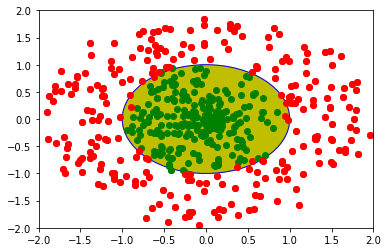

In [12]:
print_model(model1,testx)

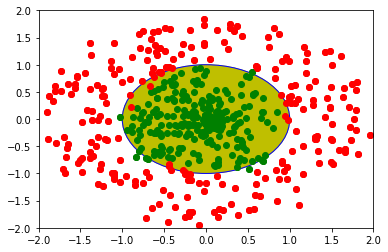

In [13]:
print_model(model2,testx)

In [14]:
model3 = generate_single_hidden_MLP(2) 
training_routine(model3,dataset,10000,gpu)

Using GPU
At iteration 0
Training loss : 0.7472878
Training accuracy : 0.4998
Validation loss : 0.7631301
Validation accuracy : 0.478
At iteration 100
Training loss : 0.6586777
Training accuracy : 0.4998
Validation loss : 0.6686867
Validation accuracy : 0.478
At iteration 200
Training loss : 0.6314499
Training accuracy : 0.5319
Validation loss : 0.63853925
Validation accuracy : 0.536
At iteration 300
Training loss : 0.6176654
Training accuracy : 0.6455
Validation loss : 0.62301683
Validation accuracy : 0.654
At iteration 400
Training loss : 0.6071533
Training accuracy : 0.6801
Validation loss : 0.6115242
Validation accuracy : 0.694
At iteration 500
Training loss : 0.59752053
Training accuracy : 0.6976
Validation loss : 0.6013632
Validation accuracy : 0.718
At iteration 600
Training loss : 0.58824074
Training accuracy : 0.7097
Validation loss : 0.591912
Validation accuracy : 0.728
At iteration 700
Training loss : 0.57916653
Training accuracy : 0.7178
Validation loss : 0.5827576
Validati

At iteration 6400
Training loss : 0.4492463
Training accuracy : 0.7823
Validation loss : 0.45663002
Validation accuracy : 0.782
At iteration 6500
Training loss : 0.44912466
Training accuracy : 0.7827
Validation loss : 0.4566796
Validation accuracy : 0.782
At iteration 6600
Training loss : 0.44900566
Training accuracy : 0.7826
Validation loss : 0.45675385
Validation accuracy : 0.782
At iteration 6700
Training loss : 0.44888878
Training accuracy : 0.7827
Validation loss : 0.4568534
Validation accuracy : 0.78
At iteration 6800
Training loss : 0.44877657
Training accuracy : 0.7827
Validation loss : 0.4569658
Validation accuracy : 0.78
At iteration 6900
Training loss : 0.44866508
Training accuracy : 0.7825
Validation loss : 0.45698887
Validation accuracy : 0.78
At iteration 7000
Training loss : 0.44855708
Training accuracy : 0.7825
Validation loss : 0.45701852
Validation accuracy : 0.782
At iteration 7100
Training loss : 0.44844648
Training accuracy : 0.7823
Validation loss : 0.4570678
Vali

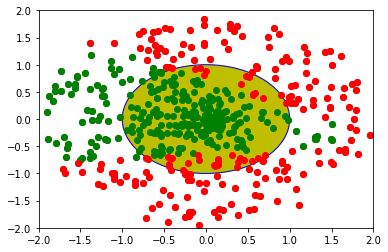

In [15]:
print_model(model3,testx)